# Курс "Python для исследователя", осень 2024

## Занятие 9. Параллелизация в Python. HTTP запросы. 

![](Python09-Parallel_extra/logo.png) 

---

# Параллелизация в Python

## Немного теории

### Закон Амдала

Распараллеливать что-нибудь очень хорошо и правильно. Но есть ли пределы распараллеливания, даже если увеличивать до бесконечности число занятых в этом процессе устройств?

Оказывается, да, и этот предел описывает простым [**законом Амдала**](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%90%D0%BC%D0%B4%D0%B0%D0%BB%D0%B0): "*В случае, когда задача разделяется на несколько частей, суммарное время её выполнения на параллельной системе не может быть меньше времени выполнения самого медленного фрагмента*".

#### Формульное выражение

Предположим, что в программе доля вычислений *a* - чисто последовательные (и никак не могут быть распараллелены). Также предположим, что у нас есть *p* одинаковых вычислителей. Тогда максимальное ускорение по сравнению с одним вычислителем, которое можно получить, используя *p* таких вычислителей, выражается формулой:

$$R = \frac{1}{a + \frac{1 - a}{p}}\xrightarrow[p\rightarrow\infty]{} \frac{1}{a}$$

Таким образом, имея половину нераспараллеливаемых вычислений (*a=0.5*), даже имея неограниченное число вычислителей, невозможно ускорить программу больше чем в 2 раза.

![](Python09-Parallel_extra/amdal.png)

### О парадигмах распараллеливания

На данный момент наибольшее распространение получили 2 классических подхода к распараллеливанию:
1. Основанный на процессах (multiprocessing)
2. Основанный на нитях (multithreading)

> Правда, есть еще такая важная ветка, как *распределённые вычисления* (и связанные с ней механизмы синхронизации). К сожалению, это не тема данного семинара.

Чем отличаются multiprocessing и multithreading? Самое важное различие - доступ к памяти:
- Если применяется multiprocessing, то создаются копии текущего процесса и каждая копия работает независимо 
- Если применяется multithreading, то запускаются т.н. "нити", каждая из которых имеет такой же полный доступ к общей памяти, как и любая другая нить

![](Python09-Parallel_extra/th_vs_pr.png)

Очевидно, что multiprocessing имеет смысл применять, когда у нас:
- есть в наличии дополнительные процессоры (ядра)
- процессы не требуют особого взаимодействия (ни между собой, ни с внешним миром)

![](Python09-Parallel_extra/pr.png)

По идее, для multithreading тоже лучше бы использовать разные процессоры (ядра), только нити могут активно общаться между собой. 

Однако, в Python не все так радужно :)

Оказывается, в Python его главный интерпретатор, CPython, не позволяет делать истинную многопоточность из-за механизма ограничения доступа, названного Global Interpreter Lock (GIL).

GIL применяется, потому что интерпретатор Питона не потоково безопасный (thread-safe). Это значит, что существует глобальная блокировка (lock) при попытке использовать питоновские объекты изнутри нитей. В каждый момент времени ровно одна нить может блокировать доступ к интерпретатору (и соответственно, к объекту). 

Создатели языка делали попытки избавиться от GIL, но тогда язык теряет существенную часть своей простоты. Написание надёжных многопоточных программ зачастую является непростой задачей. Без GIL Python станет другим языком с более высоким порогом входа.

Как выглядит работа с нитями:
![](Python09-Parallel_extra/th.png)

Как разные нити выполняются по времени:
![](Python09-Parallel_extra/GIL_description.gif)

Рассмотрим подробнее два этих подхода. Сразу заметим, что все скрипты будем пускать из отдельного файла, а не через ноутбук, иначе эффективного распараллеливания не получится :)

Также важно: будет пользоваться общепринятой практикой оформления кода в файле вида `if __name__ == "__main__":`, после чего будет идти код, который должен исполняться только если мы напрямую запускаем этот файл, а не импортируем его (что могло бы привести к печальным последствиям)

Начнем с более простого - **нитей** (или **потоков**, часто это - синонимы).

## Multithreading

### Одна нить

* делается с помощью стандартной библиотеки *`threading`*
* конструктор нити: `Thread(target=thread_function, args=args)`, где
  * `target`: это функция, которая будет запущена в отдельной нити
  * `args`: аргументы этой функции
* запуск нити происходит с помощью функции `start`

th1.py:
```python
import threading
import time

def thread_function(name):
    print(f'Thread {name}: starting')
    time.sleep(2)
    print(f'Thread {name}: finishing')

if __name__ == "__main__":
    print('Main    : before creating thread')
    x = threading.Thread(target=thread_function, args=(1,))
    print('Main    : before running thread')
    x.start()
    print('Main    : wait for the thread to finish')
    # x.join()
    print('Main    : all done')
```

In [1]:
import os
import subprocess

def run(cmd):
    print(subprocess.check_output(cmd.split(" "), stderr=subprocess.STDOUT).decode())

In [2]:
run("python Python09-Parallel_extra/th1.py")

Main    : before creating thread
Main    : before running thread
Thread 1: starting
Main    : wait for the thread to finish
Main    : all done
Thread 1: finishing



Мы передавали имя нити как аргумент (1), но можно воспользоваться:
* стандартным полем извлечения имени: `current_thread().name` (получить ссылку на главный поток программы можно с помощью `main_thread()`)
* передавать это имя в конструкторе через `name=name`

th2.py:
```python
import threading
import time

def thread_function():
    name = threading.current_thread().name
    print(f'Thread {name}: starting')
    time.sleep(2)
    print(f'Thread {name}: finishing')

if __name__ == "__main__":
    print('Main    : before creating thread')
    x = threading.Thread(target=thread_function, name='my_thread_1')
    print('Main    : before running thread')
    x.start()
    print('Main    : wait for the thread to finish')
    # x.join()
    print('Main    : all done')
```

In [3]:
run("python Python09-Parallel_extra/th2.py")

Main    : before creating thread
Main    : before running thread
Thread my_thread_1: starting
Main    : wait for the thread to finish
Main    : all done
Thread my_thread_1: finishing



Заметим, что нить на самом деле завершилась уже после завершения основного потока программы (сначала "*Main    : all done*", а затем уже "*Thread my_thread_1: finishing*"). Тем не менее, основной поток дождался завершения нити.

Однако можно запускать нити в режиме **демона**, которые вообще не привязываются к основному потоку программы, и аварийно (немедленно) завершаются при завершении основного потока программы. Для этого используется соответствующее указание в конструкторе: `daemon=True`

th3.py:
```python
import threading
import time

def thread_function():
    name = threading.current_thread().name
    print(f'Thread {name}: starting')
    time.sleep(2)
    print(f'Thread {name}: finishing')

if __name__ == "__main__":
    print('Main    : before creating thread')
    x = threading.Thread(target=thread_function, name='my_thread_1', daemon=True)
    print('Main    : before running thread')
    x.start()
    print('Main    : wait for the thread to finish')
    # x.join()
    print('Main    : all done')
```

In [4]:
run("python Python09-Parallel_extra/th3.py")

Main    : before creating thread
Main    : before running thread
Thread my_thread_1: starting
Main    : wait for the thread to finish
Main    : all done



Как видим, основной поток не стал дожидаться окончания выполнения нити ("*Thread my_thread_1: finishing*" уже нет!).

Тем не менее, иногда полезно в некотором месте программы дождаться завершения одной (или нескольких, или всех) нити. Для этого используется функция `join()`, и работает даже для демонов.

th4.py: раскомментируем `x.join()`

In [5]:
run("python Python09-Parallel_extra/th4.py")

Main    : before creating thread
Main    : before running thread
Thread my_thread_1: starting
Main    : wait for the thread to finish
Thread my_thread_1: finishing
Main    : all done



### Много нитей

Для начала поступим очень просто - создадим, вызовем и дождемся завершения в цикле.

th5.py:
```python
import threading
import time

def thread_function():
    name = threading.current_thread().name
    print(f'Thread {name}: starting')
    time.sleep(2)
    print(f'Thread {name}: finishing')

if __name__ == "__main__":
    threads = list()
    n_threads = 3
    for i in range(n_threads):
        th_name = f'my_thread_{i}'
        print(f'Main    : before creating and starting {th_name}')
        x = threading.Thread(target=thread_function, name=th_name)
        threads.append(x)
        x.start()
        
    for i in range(n_threads): 
        th_name = f'my_thread_{i}'
        print(f'Main    : before join {th_name}')
        threads[i].join()
        print(f'Main    : {th_name} done')
    
    print('Main    : done')
```

In [6]:
run("python Python09-Parallel_extra/th5.py")

Main    : before creating and starting my_thread_0
Thread my_thread_0: starting
Main    : before creating and starting my_thread_1
Thread my_thread_1: starting
Main    : before creating and starting my_thread_2
Thread my_thread_2: starting
Main    : before join my_thread_0
Thread my_thread_0: finishing
Main    : my_thread_0 done
Main    : before join my_thread_1
Thread my_thread_1: finishing
Main    : my_thread_1 done
Main    : before join my_thread_2
Thread my_thread_2: finishing
Main    : my_thread_2 done
Main    : done



Как видно, порядок вызова сохранился, однако окончание ('*finishing*') может иметь другой порядок (0,1,2 -> 1,2,0), которые еще и может отличаться при разных запусках. За это отвечает операционная система, так что будьте внимательны!

#### ThreadPoolExecutor

Тем не менее, есть гораздо более удобный метод работать со множеством (да и с одной тоже) нитей из стандартного пакета **`concurrent.futures`**: `ThreadPoolExecutor`.

Основной метод использования: вызывать конструктор `ThreadPoolExecutor(max_workers=max_workers)` оператором контекста `with`, при выходе из которого автоматически вызывается `join()` для всех созданных нитей.

При этом создание и запуск нитей можно делать:
* через функцию `map(thread_function, thread_args_iter)`, тогда итератор пройдется по `thread_args_iter` и передаст каждое новое значение на вход `thread_function()` в качестве аргумента. Будет создано столько нитей, сколько объектов пройдет итератор
* через функцию `submit(thread_function, *args, **kwargs)`, и сделать это будет нужно для каждой нити (зато аргументы передавать удобнее)

th6.py:
```python
import threading
import concurrent.futures
import time

def thread_function(a):
    name = threading.current_thread().name
    print(f'Thread {name}-{a}: starting')
    time.sleep(2)
    print(f'Thread {name}-{a}: finishing')

if __name__ == "__main__":
    n_threads = 3
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        executor.map(thread_function, range(n_threads - 1))
        executor.submit(thread_function, n_threads - 1)
    print('Main    : done')
```

In [7]:
run("python Python09-Parallel_extra/th6.py")

Thread ThreadPoolExecutor-0_0-0: starting
Thread ThreadPoolExecutor-0_1-1: starting
Thread ThreadPoolExecutor-0_2-2: starting
Thread ThreadPoolExecutor-0_0-0: finishing
Thread ThreadPoolExecutor-0_1-1: finishing
Thread ThreadPoolExecutor-0_2-2: finishing
Main    : done



#### О совместном доступе к ресурсам

Предположим, что у нас есть некоторая переменная (инициализированная, например, нулем), которую ***изменяют*** две нити (одна добавляет +1, а другая +2). Если аккуратно не позаботиться об атомарном доступе к этой переменной, то предсказать, какое значение будет на выходе - **невозможно**!

Например, в примере ниже при завершении работы двух нитей будет либо 1, либо 2 (а вот 3 - вряд ли):

th7.py:
```python
import threading
import concurrent.futures
import time

class NonAtomicUpdate:
    def __init__(self):
        self.val = 0

    def update(self, dx):
        name = threading.current_thread().name
        print(f'Thread {name}: starting')
        val = self.val
        val += dx
        time.sleep(0.1)
        self.val = val
        print(f'Thread {name}: finishing')

if __name__ == "__main__":
    n_threads = 2
    obj = NonAtomicUpdate()
    print(f'Initial val = {obj.val}') 
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        executor.submit(obj.update, 1)
        executor.submit(obj.update, 2)
    print(f'Final val = {obj.val}')    
    print('Main    : done')
```

In [8]:
run("python Python09-Parallel_extra/th7.py")

Initial val = 0
Thread ThreadPoolExecutor-0_0: starting
Thread ThreadPoolExecutor-0_1: starting
Thread ThreadPoolExecutor-0_0: finishing
Thread ThreadPoolExecutor-0_1: finishing
Final val = 2
Main    : done



Для того, чтобы делать действительно атомарные операции, необходимо **блокировать** переменные. В Питоне это делается с помощью класса `Lock`, объект которого, будучи вызванным в операторе контекста `with`, блокирует переменную только для одной нити. 

th8.py:
```python
import threading
import concurrent.futures
import time

class AtomicUpdate:
    def __init__(self):
        self.val = 0
        self._lock = threading.Lock()

    def update(self, dx):
        name = threading.current_thread().name
        with self._lock:
            print(f'Thread {name}: starting to lock')
            val = self.val
            val += dx
            time.sleep(0.1)
            self.val = val
            print(f'Thread {name}: finishing lock')

if __name__ == "__main__":
    n_threads = 2
    obj = AtomicUpdate()
    print(f'Initial val = {obj.val}') 
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        executor.submit(obj.update, 1)
        executor.submit(obj.update, 2)
    print(f'Final val = {obj.val}')    
    print('Main    : done')
```

In [9]:
run("python Python09-Parallel_extra/th8.py")

Initial val = 0
Thread ThreadPoolExecutor-0_0: starting to lock
Thread ThreadPoolExecutor-0_0: finishing lock
Thread ThreadPoolExecutor-0_1: starting to lock
Thread ThreadPoolExecutor-0_1: finishing lock
Final val = 3
Main    : done



Также для разграничения доступа ресурсов между нитями можно пользоваться классом `local`, тогда значение полей этого класса будет своим для каждой отдельной нити (и по умолчанию неинициализированным)

th9.py:
```python
import threading
import concurrent.futures
import time

def show(loc):
    name = threading.current_thread().name
    try:
        val = loc.val
    except AttributeError:
        print(f'Thread {name}, value=???')
    else:
        print(f'Thread {name}, value={val}')

def thread_init(loc, v):
    time.sleep(0.1)
    show(loc)
    loc.val = v
    show(loc)
   

if __name__ == '__main__':
    loc = threading.local()
    thread_init(loc, 0)
    n_threads = 2
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as executor:
        executor.submit(thread_init, loc, 1)
        executor.submit(thread_init, loc, 2)
    show(loc)     
```

In [10]:
run("python Python09-Parallel_extra/th9.py")

Thread MainThread, value=???
Thread MainThread, value=0
Thread ThreadPoolExecutor-0_0, value=???
Thread ThreadPoolExecutor-0_0, value=1
Thread ThreadPoolExecutor-0_1, value=???
Thread ThreadPoolExecutor-0_1, value=2
Thread MainThread, value=0



#### Модель производитель-потребитель

Наиболее продвинутая система "общения" между нитями - это модель производитель-потребитель (Producer-Consumer). 

Для обеспечения работоспособности используется потоково безопасная очередь `queue.Queue` с главными методами `put()` (поместить в очередь) и `get()` (извлечь из очередь), а также `empty()` (пуста либо нет). Очередь типа FIFO (первый вошел - первый вышел). 

Для служебной сигнализации обычно используется потоково безопасный класс `Event` с главными методами `set()` (установить флаг), `clear()` (снять флаг), `wait()` (ждать пока флаг не установлен) и `is_set()` (проверка, установлен ли флаг).

В примере ниже производитель пишет некоторое количестве информации в очередь, затем устанавливает флаг. Потребитель все это время ждет установки флага, а затем считывает все данные из очереди.

th10.py:
```python
import concurrent.futures
import queue
import threading
import time

def producer(queue, event):
    print(f"Producer will write to queue... event.is_set() = {event.is_set()}")
    for i in range(10):
        print(f'Producer writing... {9-i}')
        time.sleep(0.5)
        queue.put(i*i)
    event.set()
    print(f"Producer sent event. Exiting / event.is_set() = {event.is_set()}")

def consumer(queue, event):
    print(f"Consumer is waiting for event... event.is_set() = {event.is_set()}")
    event.wait()
    print(f"Consumer received event! event.is_set() = {event.is_set()}")
    while not queue.empty():
        num = queue.get()
        print(f"Consumer got num: {num} (remain qsize={queue.qsize()})")
    event.clear()
    print(f"Consumer cleared event. Exiting  / event.is_set() = {event.is_set()}")

if __name__ == "__main__":
    pipeline = queue.Queue(maxsize=100)
    event = threading.Event()
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        executor.submit(producer, pipeline, event)
        executor.submit(consumer, pipeline, event)
    print(f"Main: event.is_set() = {event.is_set()}")
```

In [11]:
run("python Python09-Parallel_extra/th10.py")

Producer will write to queue... event.is_set() = False
Producer writing... 9
Consumer is waiting for event... event.is_set() = False
Producer writing... 8
Producer writing... 7
Producer writing... 6
Producer writing... 5
Producer writing... 4
Producer writing... 3
Producer writing... 2
Producer writing... 1
Producer writing... 0
Producer sent event. Exiting / event.is_set() = True
Consumer received event! event.is_set() = True
Consumer got num: 0 (remain qsize=9)
Consumer got num: 1 (remain qsize=8)
Consumer got num: 4 (remain qsize=7)
Consumer got num: 9 (remain qsize=6)
Consumer got num: 16 (remain qsize=5)
Consumer got num: 25 (remain qsize=4)
Consumer got num: 36 (remain qsize=3)
Consumer got num: 49 (remain qsize=2)
Consumer got num: 64 (remain qsize=1)
Consumer got num: 81 (remain qsize=0)
Consumer cleared event. Exiting  / event.is_set() = False
Main: event.is_set() = False



## Multiprocessing

В случае с распараллеливанием по процессам, многие методы модуля **`multiprocessing`** копируют одноименные из модуля `threading`.  

**Внимание** [*замечание для счастливых пользователей Windows*]: в случае с разными процессами вывод на экран порой трудно понять (порядок вывода практически не кореллирует с очередностью процессов), в особенности с дочерними (т.е. не главным процессом main) процессами, т.к. главный процесс сначала ждет, пока все дополнительные процессы завершатся, и только затем выводит. 

[Цитата из официальной документации](https://docs.python.org/3/howto/logging-cookbook.html#logging-to-a-single-file-from-multiple-processes):
> Although logging is thread-safe, and logging to a single file from multiple threads in a single process is supported, logging to a single file from multiple processes is not supported, because there is no standard way to serialize access to a single file across multiple processes in Python. 

А это значит, что выводы будут блоками: сначала полный вывод одного процесса, затем другого, и т.д.

Также воспользуемся дополнительным модулем логирования `logging` для детального вывода в `stderr` порядка запуска процессов

* конструктор процесса: `Process(target=process_function, args=args, name=name)`, где
  * `target`: это функция, которая будет запущена в отдельном процессе
  * `args`: аргументы этой функции
  * `name`: имя процесса
* запуск процесса происходит с помощью функции `start`

pr1.py:
```python
import multiprocessing
import time
import logging

def process_function(v):
    name = multiprocessing.current_process().name
    print(f'Process {name} (arg={v}): starting')
    time.sleep(2)
    print(f'Process {name} (arg={v}): finishing')

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    print('Main    : before creating process')
    x = multiprocessing.Process(target=process_function, args=(111,), name='my_process_1')
    print('Main    : before running process')
    x.start()
    print('Main    : wait for the process to finish')
    # x.join()
    print('Main    : all done')
```

In [12]:
run("python Python09-Parallel_extra/pr1.py")

Main    : before creating process
Main    : before running process
Main    : wait for the process to finish
Main    : all done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] calling join() for process my_process_1
[INFO/my_process_1] child process calling self.run()
[INFO/my_process_1] process shutting down
[INFO/my_process_1] process exiting with exitcode 0
Process my_process_1 (arg=111): starting
Process my_process_1 (arg=111): finishing



Как видим, сначала полный вывод главного процесса, который в самом конце дождался завершения дочернего процесса.

Если же мы не хотим при завершении главного процесса дожидаться результатов дочерних процессов, объявляем их как `daemon=True`

pr2.py:
```python
import multiprocessing
import time
import logging

def process_function():
    name = multiprocessing.current_process().name
    print(f'Process {name}: starting')
    time.sleep(2)
    print(f'Process {name}: finishing')

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    print('Main    : before creating process')
    x = multiprocessing.Process(target=process_function, name='my_process_1', daemon=True)
    print('Main    : before running process')
    x.start()
    print('Main    : wait for the process to finish')
    # x.join()
    print('Main    : all done')
```

In [13]:
run("python Python09-Parallel_extra/pr2.py")

Main    : before creating process
Main    : before running process
Main    : wait for the process to finish
Main    : all done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] calling terminate() for daemon my_process_1
[INFO/MainProcess] calling join() for process my_process_1



Также можно не дожидаться окончания работы главного процесса, а подождать завершения дочерних процессов в определенном месте - это делается с помощью `join()` (работает и для демонов!)

pr3.py: просто раскомментируем `x.join()`

In [14]:
run("python Python09-Parallel_extra/pr3.py")

Main    : before creating process
Main    : before running process
[INFO/my_process_1] child process calling self.run()
[INFO/my_process_1] process shutting down
[INFO/my_process_1] process exiting with exitcode 0
Process my_process_1: starting
Process my_process_1: finishing
Main    : wait for the process to finish
Main    : all done
[INFO/MainProcess] process shutting down



### Много процессов

#### Pool

* Часто нужно создавать гораздо больше одного дочернего процесса. Обычно создают N-1 дочерних процессов, где N - это число ядер на Вашем компьютере. Функция `cpu_count()` позволяет узнать это количество.

* Для работы с необходимым количеством дочерних процессов (с автоматическим ожиданием их завершения без явного вызова `join()`) модуль `multiprocessing` предоставляет инструмент `Pool(processes=num_proc)`

* Для запуска пула дочерних процессов используется функция `map(process_function, iter)`, где `iter` - это итератор (в простейшем случае - список) для перебора входов для функции процесса `process_function`

pr4.py:
```python
import multiprocessing
import time
import logging

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def process_function(x):
    name = multiprocessing.current_process().name
    print_proc('starting')
    time.sleep(0.1)
    print_proc('finishing')
    return x**2

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    num_cores = multiprocessing.cpu_count()
    num_proc = 7#num_cores - 1 # not counting Main
    print_proc(f'number of cores = {num_cores}')
    xit = [i for i in range(1, num_proc + 1)]
    print_proc('before creating pool')
    pool = multiprocessing.Pool(processes=num_proc)
    print_proc('before running processes')
    res = pool.map(process_function, xit)
    print_proc(f'result of processes - {res}')
    print_proc('all done')
```

In [15]:
run("python Python09-Parallel_extra/pr4.py")

Process MainProcess: number of cores = 8
Process MainProcess: before creating pool
[INFO/ForkPoolWorker-1] child process calling self.run()
[INFO/ForkPoolWorker-2] child process calling self.run()
[INFO/ForkPoolWorker-3] child process calling self.run()
[INFO/ForkPoolWorker-4] child process calling self.run()
[INFO/ForkPoolWorker-5] child process calling self.run()
[INFO/ForkPoolWorker-6] child process calling self.run()
[INFO/ForkPoolWorker-7] child process calling self.run()
Process MainProcess: before running processes
Process MainProcess: result of processes - [1, 4, 9, 16, 25, 36, 49]
Process MainProcess: all done
[INFO/MainProcess] process shutting down
[INFO/ForkPoolWorker-1] process shutting down
[INFO/ForkPoolWorker-2] process shutting down
[INFO/ForkPoolWorker-1] process exiting with exitcode 0
[INFO/ForkPoolWorker-3] process shutting down
Process ForkPoolWorker-1: starting
Process ForkPoolWorker-1: finishing
[INFO/ForkPoolWorker-2] process exiting with exitcode 0
[INFO/ForkP

Если `process_function` принимает на вход больше одного параметра, то используется `starmap` вместо `map`, а `iter` должен итерировать по *наборам* параметров (в простейшем случае - по кортежам), которые потом с помощью звездочки преобразуются в обычноe перечисление параметров.

pr5.py:
```python
import multiprocessing
import time
import logging

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def process_function(x, y):
    name = multiprocessing.current_process().name
    print_proc('starting')
    time.sleep(0.1)
    print_proc('finishing')
    return x + y

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    num_cores = multiprocessing.cpu_count()
    num_proc = 7#num_cores - 1 # not counting Main
    print_proc(f'number of cores = {num_cores}')
    xit = [(i, i + 1) for i in range(1, num_proc + 1)]
    print_proc('before creating pool')
    pool = multiprocessing.Pool(processes=num_proc)
    print_proc('before running processes')
    res = pool.starmap(process_function, xit)
    print_proc(f'result of processes - {res}')
    print_proc('all done')
```

In [16]:
run("python Python09-Parallel_extra/pr5.py")

Process MainProcess: number of cores = 8
Process MainProcess: before creating pool
[INFO/ForkPoolWorker-1] child process calling self.run()
[INFO/ForkPoolWorker-2] child process calling self.run()
[INFO/ForkPoolWorker-3] child process calling self.run()
[INFO/ForkPoolWorker-4] child process calling self.run()
[INFO/ForkPoolWorker-5] child process calling self.run()
[INFO/ForkPoolWorker-6] child process calling self.run()
[INFO/ForkPoolWorker-7] child process calling self.run()
Process MainProcess: before running processes
Process MainProcess: result of processes - [3, 5, 7, 9, 11, 13, 15]
Process MainProcess: all done
[INFO/MainProcess] process shutting down
[INFO/ForkPoolWorker-3] process shutting down
[INFO/ForkPoolWorker-1] process shutting down
[INFO/ForkPoolWorker-2] process shutting down
[INFO/ForkPoolWorker-4] process shutting down
[INFO/ForkPoolWorker-6] process shutting down
[INFO/ForkPoolWorker-3] process exiting with exitcode 0
[INFO/ForkPoolWorker-5] process shutting down
P

#### ProcessPoolExecutor

Тем не менее, наиболее удобно пользоваться стандартным, уже ранее упомянутым интерфейсом, из модуля **`concurrent.futures`** - `ProcessPoolExecutor` (полная аналогия с `ThreadPoolExecutor`).

Основной метод использования: вызывать конструктор `ProcessPoolExecutor(max_workers=max_workers)` оператором контекста `with`, при выходе из которого автоматически вызывается `join()` для всех созданных процессов.

При этом создание и запуск процессов можно делать:
* через функцию `map(process_function, process_args_iter)`, тогда итератор пройдется по `process_args_iter` и передаст каждое новое значение на вход `process_function()` в качестве аргумента. Будет создано столько процессов, сколько объектов пройдет итератор
* через функцию `submit(process_function, *args, **kwargs)`, и сделать это будет нужно для каждого процесса (зато аргументы передавать удобнее) (тут нет `starmap`). `submit()` возвращает объект класса `Future`, который инкапсулирует асинхронные вызовы. После этого для объекта Future можно вызвать метод `result()`, получить результат работы процесса. Если к моменту вызова `result()` процесс ещё не завершился, то программа дожётся его завершения.
* результат выхода `process_function()` можно получить с помощью `result()`

pr6.py:
```python
import multiprocessing
import concurrent.futures
import time
import logging

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def process_function(x, y):
    name = multiprocessing.current_process().name
    print_proc('starting')
    time.sleep(0.1)
    print_proc('finishing')
    return x + y

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    num_cores = multiprocessing.cpu_count()
    num_proc = 7#num_cores - 1 # not counting Main
    print_proc(f'number of cores = {num_cores}')
    print_proc('before creating & running pool')
    res_arr = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_proc) as executor:
        for i in range(1, num_proc+1):
            res_arr.append(executor.submit(process_function, i, i+1))
    res_arr = [r.result() for r in res_arr]
    print_proc(f'result of processes - {res_arr}')
    print_proc('all done')
```

In [17]:
run("python Python09-Parallel_extra/pr6.py")

Process MainProcess: number of cores = 8
Process MainProcess: before creating & running pool
[INFO/ForkProcess-1] child process calling self.run()
[INFO/ForkProcess-2] child process calling self.run()
[INFO/ForkProcess-3] child process calling self.run()
[INFO/ForkProcess-4] child process calling self.run()
[INFO/ForkProcess-5] child process calling self.run()
[INFO/ForkProcess-6] child process calling self.run()
[INFO/ForkProcess-7] child process calling self.run()
[INFO/ForkProcess-1] process shutting down
[INFO/ForkProcess-2] process shutting down
[INFO/ForkProcess-3] process shutting down
[INFO/ForkProcess-4] process shutting down
[INFO/ForkProcess-7] process shutting down
[INFO/ForkProcess-1] process exiting with exitcode 0
Process ForkProcess-1: starting
Process ForkProcess-1: finishing
[INFO/ForkProcess-5] process shutting down
[INFO/ForkProcess-2] process exiting with exitcode 0
[INFO/ForkProcess-3] process exiting with exitcode 0
Process ForkProcess-3: starting
Process ForkPro

#### О совместном доступе к ресурсам

#### Общая память

По умолчанию, все процессы имеют отдельную копию главной памяти, и изменения какой-нибудь переменной в одном процессе не меняет ее значения в другом, в т.ч. и в главном

pr7.py:
```python
import multiprocessing
import concurrent.futures
import time
import logging

data = [1, 2, 3]

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def process_function(x):
    name = multiprocessing.current_process().name
    print_proc('starting')
    data.append(x)
    print_proc(f'data = {data}')
    time.sleep(0.1)
    print_proc('finishing')

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    num_cores = multiprocessing.cpu_count()
    num_proc = num_cores - 1 # not counting Main
    print_proc(f'number of cores = {num_cores}')
    print_proc(f'data = {data}')
    print_proc('before creating & running pool')
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_proc) as executor:
        executor.map(process_function, range(100, num_proc+100))
    print_proc(f'data = {data}')
    print_proc('all done')
```

In [18]:
run("python Python09-Parallel_extra/pr7.py")

Process MainProcess: number of cores = 8
Process MainProcess: data = [1, 2, 3]
Process MainProcess: before creating & running pool
[INFO/ForkProcess-1] child process calling self.run()
[INFO/ForkProcess-2] child process calling self.run()
[INFO/ForkProcess-3] child process calling self.run()
[INFO/ForkProcess-4] child process calling self.run()
[INFO/ForkProcess-5] child process calling self.run()
[INFO/ForkProcess-6] child process calling self.run()
[INFO/ForkProcess-7] child process calling self.run()
[INFO/ForkProcess-1] process shutting down
[INFO/ForkProcess-5] process shutting down
[INFO/ForkProcess-2] process shutting down
[INFO/ForkProcess-4] process shutting down
[INFO/ForkProcess-1] process exiting with exitcode 0
[INFO/ForkProcess-7] process shutting down
Process ForkProcess-1: starting
Process ForkProcess-1: data = [1, 2, 3, 100]
Process ForkProcess-1: finishing
[INFO/ForkProcess-6] process shutting down
[INFO/ForkProcess-3] process shutting down
[INFO/ForkProcess-5] proces

И хотя нужно максимально изолировать совместный доступ к ресурсам, все же иногда это делать нужно. Для этого используются безопасные классы `Value(typecode_or_type, val)` и `Array(typecode_or_type, size_or_initializer)`, где:
* `typecode_or_type` - односимвольный код [отсюда](https://docs.python.org/3/library/array.html#module-array) либо идентификатор из [ctypes](https://docs.python.org/3/library/ctypes.html#fundamental-data-types) используемого типа
  * 'i' - целый int32
  * 'd' - дробный double64
  * 'c' - в сочетании с `Array` даст строку
* `val` - значение для инициализации
* `size_or_initializer` - либо размер массива (инициализируем нулями), либо последовательность, которой инициализируем

При этом значение можно получить как:
* `.value` для объекта `Value`,
* `[i]` для объекта `Array`.

При этом возможен одновременный доступ к ресурсам на изменение. Чтобы избежать этого, испольуется конструкция
```python
with obj.get_lock():
    # change obj
```

Также обратите внимание, что размеры массивов\строк не меняем, меняем только их содержимое (так как память выделяется сразу).

pr8.py:
```python
import multiprocessing
import concurrent.futures
import time
import logging

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def process_function(x_d, x_s, x_a):
    time.sleep(0.1)
    name = multiprocessing.current_process().name
    print_proc('starting')
    with x_d.get_lock():
        x_d.value += 1
    with x_s.get_lock():
        x_s.value = x_s.value.upper()
    with x_a.get_lock():
        x_a[1] *= 2
    print_proc(f'x_d = {x_d.value}')
    print_proc(f'x_s = {x_s.value}')
    print_proc(f'x_a = {[a for a in x_a]}')   
    print_proc('finishing')

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    num_cores = multiprocessing.cpu_count()
    num_proc = num_cores - 1 # not counting Main
    print_proc(f'number of cores = {num_cores}')
    x_d = multiprocessing.Value('d', 0)
    x_s = multiprocessing.Array('c', b"Hello!")
    x_a = multiprocessing.Array('d', [1.0, 2.5, 4.0])
    print_proc(f'x_d = {x_d.value}')
    print_proc(f'x_s = {x_s.value}')
    print_proc(f'x_a = {[a for a in x_a]}')
    print_proc('before creating & running pool')
    
    processes = [multiprocessing.Process(target=process_function, args=(x_d, x_s, x_a)) for _ in range(num_proc)]
    for p in processes:
        p.start()
    for p in processes:
        p.join()    

    print_proc('after finishing pool')
    print_proc(f'x_d = {x_d.value}')
    print_proc(f'x_s = {x_s.value}')
    print_proc(f'x_a = {[a for a in x_a]}')
    print_proc('all done')
```

In [19]:
run("python Python09-Parallel_extra/pr8.py")

[INFO/MainProcess] allocating a new mmap of length 4096
Process MainProcess: number of cores = 8
Process MainProcess: x_d = 0.0
Process MainProcess: x_s = b'Hello!'
Process MainProcess: x_a = [1.0, 2.5, 4.0]
Process MainProcess: before creating & running pool
[INFO/Process-1] child process calling self.run()
[INFO/Process-2] child process calling self.run()
[INFO/Process-3] child process calling self.run()
[INFO/Process-4] child process calling self.run()
[INFO/Process-5] child process calling self.run()
[INFO/Process-6] child process calling self.run()
[INFO/Process-7] child process calling self.run()
[INFO/Process-1] process shutting down
[INFO/Process-1] process exiting with exitcode 0
Process Process-1: starting
Process Process-1: x_d = 1.0
Process Process-1: x_s = b'HELLO!'
Process Process-1: x_a = [1.0, 5.0, 4.0]
Process Process-1: finishing
[INFO/Process-2] process shutting down
[INFO/Process-2] process exiting with exitcode 0
Process Process-2: starting
Process Process-2: x_d =

#### Механизмы синхронизации Queue / Pipe

Несмотря на возможность иметь общий доступ к памяти через классы Value/Array и грамотное использование блокировки, вышеописанные методы крайне не рекомендуются из-за ненулевой вероятности неправильной блокировки, разного поведения в Windows/Unix-системах, заранее определенных размеров массивов и крайне непрозрачной, а иногда и невозможной работы с пулами процессов (Pool / ProcessPoolExecutor).

#### Производитель-потребитель (Producer-Consumer)

Наиболее продвинутая система "общения" между процессами - это модель производитель-потребитель (Producer-Consumer).

Первый способ реализации - с помощью **очереди**.

Для обеспечения работоспособности используется процессорно безопасная очередь `Manager().Queue` с главными методами `put()` (поместить в очередь) и `get()` (извлечь из очередь), а также `empty()` (пуста либо нет). Очередь типа FIFO (первый вошел - первый вышел).

Для служебной сигнализации обычно используется процессорно безопасное событие `Manager().Event` с главными методами `set()` (установить флаг), `clear()` (снять флаг), `wait()` (ждать пока флаг не установлен) и `is_set()` (проверка, установлен ли флаг).

В примере ниже производитель пишет некоторое количестве информации в очередь, затем устанавливает флаг. Потребитель все это время ждет установки флага, а затем считывает все данные из очереди.

pr9.py:
```python
import concurrent.futures
import multiprocessing
import time
import logging

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def producer(queue, event):
    print_proc(f"Producer will write to queue... event.is_set() = {event.is_set()}")
    for i in range(10):
        print_proc(f'Producer writing... {9-i}')
        time.sleep(0.5)
        queue.put(i*i)
    event.set()
    print_proc(f"Producer sent event. Exiting / event.is_set() = {event.is_set()}")

def consumer(queue, event):
    print_proc(f"Consumer is waiting for event... event.is_set() = {event.is_set()}")
    event.wait()
    print_proc(f"Consumer received event! event.is_set() = {event.is_set()}")
    while not queue.empty():
        num = queue.get()
        print_proc(f"Consumer got num: {num} (remain qsize={queue.qsize()})")
    event.clear()
    print_proc(f"Consumer cleared event. Exiting  / event.is_set() = {event.is_set()}")

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    manager = multiprocessing.Manager()
    pipeline = manager.Queue(maxsize=100)
    event = manager.Event()
    with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
        executor.submit(producer, pipeline, event)
        executor.submit(consumer, pipeline, event)
    print_proc(f"Main: event.is_set() = {event.is_set()}")
```

In [20]:
run("python Python09-Parallel_extra/pr9.py")

[INFO/SyncManager-1] child process calling self.run()
[INFO/SyncManager-1] created temp directory /tmp/pymp-b1helxf0
[INFO/SyncManager-1] manager serving at '/tmp/pymp-b1helxf0/listener-bysej6sk'
[INFO/ForkProcess-2] child process calling self.run()
[INFO/ForkProcess-3] child process calling self.run()
[INFO/ForkProcess-2] process shutting down
[INFO/ForkProcess-3] process shutting down
[INFO/ForkProcess-2] process exiting with exitcode 0
Process ForkProcess-2: Producer will write to queue... event.is_set() = False
Process ForkProcess-2: Producer writing... 9
Process ForkProcess-2: Producer writing... 8
Process ForkProcess-2: Producer writing... 7
Process ForkProcess-2: Producer writing... 6
Process ForkProcess-2: Producer writing... 5
Process ForkProcess-2: Producer writing... 4
Process ForkProcess-2: Producer writing... 3
Process ForkProcess-2: Producer writing... 2
Process ForkProcess-2: Producer writing... 1
Process ForkProcess-2: Producer writing... 0
Process ForkProcess-2: Produc

Но по сравнению с `threading` в модуле `multiprocessing` есть интересный класс `Pipe`, который предоставляет возможность использовать дву- (при `duplex=True`) или одностороннюю (при `duplex=False`) "трубу" передачи данных между двумя процессами. При этом после вызова конструктора класса мы получаем два конца этой "трубы": `pipe_recv, pipe_send = Pipe(duplex=True)`

Полезные методы:
* `send(message)` - послать сообщение (если этот конец трубы поддерживает посылку)
* `recv(message)` - принять сообщение (если этот конец трубы поддерживает принятие)
* `close()` - закрыть конец трубы

pr10.py:
```python
import concurrent.futures
import multiprocessing
import time
import logging

def print_proc(mes):
    name = multiprocessing.current_process().name
    print(f'Process {name}: {mes}')
    
def producer(pipe):
    print_proc(f"Producer will write to queue...")
    for i in range(10):
        print_proc(f'Producer writing... {i}*{i}')
        time.sleep(0.5)
        pipe.send(i*i)
    print_proc(f'Producer writing... DONE')
    pipe.send('DONE')
    pipe.close()
    print_proc(f"Producer finishing.")

def consumer(pipe):
    print_proc(f"Consumer is waiting for event...")
    while True:
        mes = pipe.recv()
        print_proc(f"Consumer got: {mes}")
        if mes == 'DONE':
            break
    pipe.close()
    print_proc(f"Consumer finishing")

if __name__ == "__main__":
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    pipe_cons, pipe_prod = multiprocessing.Pipe()
    with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
        executor.submit(producer, pipe_prod)
        executor.submit(consumer, pipe_cons)
    print_proc(f"All is done")
```

In [21]:
run("python Python09-Parallel_extra/pr10.py")

[INFO/ForkProcess-1] child process calling self.run()
[INFO/ForkProcess-2] child process calling self.run()
[INFO/MainProcess] created temp directory /tmp/pymp-x3lm4enq
[INFO/ForkProcess-1] process shutting down
[INFO/ForkProcess-2] process shutting down
[INFO/ForkProcess-1] process exiting with exitcode 0
[INFO/ForkProcess-2] process exiting with exitcode 0
Process ForkProcess-1: Producer will write to queue...
Process ForkProcess-1: Producer writing... 0*0
Process ForkProcess-1: Producer writing... 1*1
Process ForkProcess-1: Producer writing... 2*2
Process ForkProcess-1: Producer writing... 3*3
Process ForkProcess-1: Producer writing... 4*4
Process ForkProcess-1: Producer writing... 5*5
Process ForkProcess-1: Producer writing... 6*6
Process ForkProcess-1: Producer writing... 7*7
Process ForkProcess-1: Producer writing... 8*8
Process ForkProcess-1: Producer writing... 9*9
Process ForkProcess-1: Producer writing... DONE
Process ForkProcess-1: Producer finishing.
Process ForkProcess-2: 

## Параллелизация в Python: выводы

* В каждый момент времени внутри одного процесса работает ровно одна нить (поток)
* Реальное распараллеливание - это `multiprocessing`, `threading` - это больше про совместный доступ
  * Поэтому `multiprocessing` направлен на ускорение,
  * А `threading` - на уменьшение простоя
* `multiprocessing` - для тяжелых вычислений, `threading` - для активного использования I/O
* Для `multiprocessing` используем число дочерних процессов НЕ БОЛЕЕ чем `cores_count - 1`, а для `threading` число нитей как `cores_count * k`, где `k > 1` - некий коэффициент, подбираемый под текущую задачу
* Сложная тема: отладка [не в этот раз]
* **Совместный доступ к ресурсам** - это простой способ выиграть в лотерее "*1000 и 1 способ прострелить себе колено*"

![](Python09-Parallel_extra/koleno.gif)

При подготовке материала использовалась документация Python ([threading](https://docs.python.org/3/library/threading.html), [multiprocessing](https://docs.python.org/3/library/multiprocessing.html), [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html)), а также ресуры [realpython.com](https://realpython.com/intro-to-python-threading/) и [medium.com](https://medium.com/contentsquare-engineering-blog/multithreading-vs-multiprocessing-in-python-ece023ad55a).

---

# Работа с HTTP

## Типы запросов

Основой работой с http является формальный язык запросов к серверу: http request. Типов запросов много (в т.ч. такие как `PUT`, `HEAD`, `DELETE`, `LINK`, `UNLINK`, `OPTIONS`, `PATCH` и тп), но мы кратко рассмотрим только два самых главных из них:
* `GET`: получение данных
* `POST`: отправка данных

## Структура запросов и ответов

В запросе перечисляются такие сущности как:
* Метод запроса
* Путь к ресурсу на сервере
* Версия протокола HTTP
* Заголовки (например, идентификатор клиента, принимаемые языки и кодировка и пр.)

![](Python09-Parallel_extra/HTTP_Request.png) 

В ответе перечисляются такие сущности как:
* Версия протокола HTTP
* Код статуса ответа
* Расшифровка статуса ответа
* Заголовки (например, дата последнего изменения, размер и тип тела ответа и пр.)
* Тело ответа (если есть)

![](Python09-Parallel_extra/HTTP_Response.png)

Коды HTTP находятся в диапазоне от 1XX до 5XX (200, 404, 500 - скорее всего, видели):
* 1XX — информация
* 2XX — успешно
* 3XX — перенаправление
* 4XX — ошибка клиента (ошибка на вашей стороне)
* 5XX — ошибка сервера (ошибка на их стороне)

Основная цель - получить ответ сервера 200.

## Библиотеки для работы с http-запросами

Основными библиотеками для работы с http-запросами являются:
* `socket`
* `http`
* `urllib` / `urllib3`
* `requests`

Каждая следующая является в некотором роде надстройкой над предыдущей (функциональности меньше, удобства больше), поэтому возмьем наиболее простую и удобную - библиотеку `requests`

## Библиотека `requests`

Основные фичи `requests`:
* Множество методов http аутентификации
* Сессии с куками
* Полноценная поддержка SSL
* Различные методы-плюшки вроде .json(), которые вернут данные в нужном формате
* Проксирование
* Грамотная и логичная работа с исключениями

В качестве удобного сервера для проверки http-запросов будем использовать очень удобный сервис [httpbin.org](https://httpbin.org/)

### `GET`,  заголовки и тело ответа

Подключаем библиотеку:

In [22]:
import requests

Проверим методом `GET` два ресурса: существующий и несуществующий - и посмотрим на ответы:

In [23]:
urls = ['https://httpbin.org/get', 'https://httpbin.org/ggg']
for url in urls:
    res = requests.get(url)
    print(f'{url} response = {res}')
    print(f'OK: {res.ok}')
    print(f'Reason: {res.reason}')
    print(f'Status code: {res.status_code}')

https://httpbin.org/get response = <Response [200]>
OK: True
Reason: OK
Status code: 200
https://httpbin.org/ggg response = <Response [404]>
OK: False
Reason: NOT FOUND
Status code: 404


Теперь посмотрим на заголовки ответа:

In [24]:
res = requests.get('https://httpbin.org/get')
print(f'Headers = {res.headers}')
print(f"Headers / Server = {res.headers['server']}") # согласно RFC, имена регистро-независимы

Headers = {'Date': 'Tue, 26 Nov 2024 12:33:41 GMT', 'Content-Type': 'application/json', 'Content-Length': '318', 'Connection': 'keep-alive', 'Server': 'gunicorn/19.9.0', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Credentials': 'true'}
Headers / Server = gunicorn/19.9.0


а также на все тело ответа - в бинарном формате:

In [25]:
print(f'Content = {res.content}')

Content = b'{\n  "args": {}, \n  "headers": {\n    "Accept": "*/*", \n    "Accept-Encoding": "gzip, deflate, br, zstd", \n    "Host": "httpbin.org", \n    "User-Agent": "python-requests/2.32.3", \n    "X-Amzn-Trace-Id": "Root=1-6745c025-5f58c15f61c08dff2ecc92a6"\n  }, \n  "origin": "159.138.216.23", \n  "url": "https://httpbin.org/get"\n}\n'


в текстовом формате:

In [26]:
print(f'Text = {res.text}')

Text = {
  "args": {}, 
  "headers": {
    "Accept": "*/*", 
    "Accept-Encoding": "gzip, deflate, br, zstd", 
    "Host": "httpbin.org", 
    "User-Agent": "python-requests/2.32.3", 
    "X-Amzn-Trace-Id": "Root=1-6745c025-5f58c15f61c08dff2ecc92a6"
  }, 
  "origin": "159.138.216.23", 
  "url": "https://httpbin.org/get"
}



а также в формате [JSON](https://ru.wikipedia.org/wiki/JSON) - *JavaScript Object Notation*, а именно набор пар `ключ : значение`:

In [27]:
print(f'JSON = {res.json()}')

JSON = {'args': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.32.3', 'X-Amzn-Trace-Id': 'Root=1-6745c025-5f58c15f61c08dff2ecc92a6'}, 'origin': '159.138.216.23', 'url': 'https://httpbin.org/get'}


Кодировку можно посмотреть или поменять с помощью поля `.encoding`.

Обратим внимание на поле `headers` в теле ответа:

In [28]:
res = requests.get('https://httpbin.org/get')
print(res.json()['headers'])

{'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.32.3', 'X-Amzn-Trace-Id': 'Root=1-6745c02a-0bd194256b3de4f5733ee8e5'}


На самом деле это - заголовки запроса, а не ответа. Обычно формируются браузером либо программой, которая делает запросы. Посмотреть заголовки запроса в явном виде можно через поле `.request.headers` (видим, здесь немного меньше - остальное добавилось в процессе посылки запроса):

In [29]:
res = requests.get('https://httpbin.org/get')
print(f'Request headers: {res.request.headers}')

Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive'}


На тело же запроса (в `GET` его, конечно, нет - только в `POST`) можно посмотреть с помощью `.request.body`:

In [30]:
res = requests.get('https://httpbin.org/get')
print(f'Request body: {res.request.body}')

Request body: None


### `GET`, параметры запроса

Можем поменять заголовок запроса с помощью параметра `headers`:

In [31]:
res = requests.get('https://httpbin.org/get', headers={'user-agent': 'my-app/0.0.1'})
print(f'Request headers: {res.request.headers}')

Request headers: {'user-agent': 'my-app/0.0.1', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive'}


Часто запросы содержат кучу параметров, таких как разные идентификаторы, номера страниц и тп. Все эти параметры можно зашифровать собственноручно в url запроса, а можно предоставить дело библиотеке с помощью параметра `params`, а посмотреть на получившийся запрос с помощью поля `.request.url`:

In [32]:
res = requests.get('https://httpbin.org/get', params={'p1': 'abc', 'p2': 123})
print(f'URL: {res.request.url}')

URL: https://httpbin.org/get?p1=abc&p2=123


Зачастую на сайтах встречается так называемая "HTTP Basic Auth" авторизация, которая реализуется посредством http-сервера (а не сторонних движков), и выглядит [вот так](https://httpbin.org/basic-auth/user/passwd):

![](Python09-Parallel_extra/basic_auth.png)

Оказывается, эту авторизацию тоже можно обходить используя параметр `auth`:

In [33]:
res = requests.get('https://httpbin.org/basic-auth/user/passwd', auth=('user', 'passwd'))
print(f'URL: {res.request.url}')
print(f'Request headers: {res.request.headers}')
print(f'Responce body: {res.json()}')

URL: https://httpbin.org/basic-auth/user/passwd
Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'Authorization': 'Basic dXNlcjpwYXNzd2Q='}
Responce body: {'authenticated': True, 'user': 'user'}


"*dXNlcjpwYXNzd2Q=*" в base64-кодировке значит "*user:passwd*".

Если вы хотите использовать одну и ту же аутентификацию для нескольких запросов (да и вообще одни и те же параметры по умолчанию), то лучше использовать сессии `Session`:

In [34]:
with requests.Session() as session:
    session.auth = ('user', 'passwd')
    res = session.get('https://httpbin.org/basic-auth/user/passwd')
    print(f'OK: {res.ok}')
    res = session.get('https://httpbin.org/basic-auth/user/passwd')
    print(f'OK: {res.ok}')

OK: True
OK: True


Если вы сидите за прокси, то их также можно задавать с помощью параметра `proxies` (поддерживаются множественные протоколы типа 'http', 'https', 'ftp'):

```python
with requests.Session() as session:
    session.proxies = {'https' : 'https://188.166.50.225:3128'}
    res = session.get('https://httpbin.org/ip')
    print(f'URL: {res.request.url}')
    print(f'Responce body: {res.json()}')
```

Можно задавать таймауты на: ожидание времени соединения с сервером, ожидание начала скачивания данных с сервера. Делается с помощью параметра `timeout`:

In [35]:
response = requests.get('https://httpbin.org', timeout=(0.00001, 10))

ConnectTimeout: HTTPSConnectionPool(host='httpbin.org', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7e6eb8509290>, 'Connection to httpbin.org timed out. (connect timeout=1e-05)'))

Ловить исключение будем дальше, сейчас просто видим, что это работает.

### `POST` и отправка на сервер данных

Простые параметры можно передавать через `GET`, но тексты или файлы - уже лучше через `POST`.

Давайте сначала передадим несколько параметров с помощью функции `post` и параметра `data` (обратите внимание на аналогию с `params`):

In [36]:
res = requests.post('https://httpbin.org/post', data={'p1': 'abc', 'p2': 123})
print(f'URL: {res.request.url}')
print(f'Request headers: {res.request.headers}')
print(f'Request body: {res.request.body}')
print(f'Responce body: {res.json()}')

URL: https://httpbin.org/post
Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-Length': '13', 'Content-Type': 'application/x-www-form-urlencoded'}
Request body: p1=abc&p2=123
Responce body: {'args': {}, 'data': '', 'files': {}, 'form': {'p1': 'abc', 'p2': '123'}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Content-Length': '13', 'Content-Type': 'application/x-www-form-urlencoded', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.32.3', 'X-Amzn-Trace-Id': 'Root=1-6745c04e-791737974e5159e7224ac169'}, 'json': None, 'origin': '159.138.216.23', 'url': 'https://httpbin.org/post'}


Видим, что теперь параметр `.request.body` показывает наши переданные параметры (в то время как URL запроса не поменялся).

Передача файла ведется с помощью параметра `files` (который должен быть перед этим открыт с помощью `open`):

In [37]:
res = requests.post('https://httpbin.org/post', 
                    files={'file' : open('Python09-Parallel_extra/table.csv', 'rb')})
print(f'Request headers: {res.request.headers}')
print(f'Request body: {res.request.body}')
print(f'Responce body: {res.json()}')

Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-Length': '166', 'Content-Type': 'multipart/form-data; boundary=2f073588ef0f208290b481a1e91b1abb'}
Request body: b'--2f073588ef0f208290b481a1e91b1abb\r\nContent-Disposition: form-data; name="file"; filename="table.csv"\r\n\r\nparam,val\nx,100\ny,200\r\n--2f073588ef0f208290b481a1e91b1abb--\r\n'
Responce body: {'args': {}, 'data': '', 'files': {'file': 'param,val\nx,100\ny,200'}, 'form': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Content-Length': '166', 'Content-Type': 'multipart/form-data; boundary=2f073588ef0f208290b481a1e91b1abb', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.32.3', 'X-Amzn-Trace-Id': 'Root=1-6745c051-0c649aab68a0b0a86d0121ab'}, 'json': None, 'origin': '159.138.216.23', 'url': 'https://httpbin.org/post'}


Можно послать и несколько файлов:

In [38]:
res = requests.post('https://httpbin.org/post', 
                    files=[('file', ('table.csv', open('Python09-Parallel_extra/table.csv', 'rb'))), 
                           ('file', ('table2.csv', open('Python09-Parallel_extra/table2.csv', 'rb')))])
print(f'Request headers: {res.request.headers}')
print(f'Request body: {res.request.body}')
print(f'Responce body: {res.json()}')

Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-Length': '301', 'Content-Type': 'multipart/form-data; boundary=cea1918127d4c7c2b04894431923170e'}
Request body: b'--cea1918127d4c7c2b04894431923170e\r\nContent-Disposition: form-data; name="file"; filename="table.csv"\r\n\r\nparam,val\nx,100\ny,200\r\n--cea1918127d4c7c2b04894431923170e\r\nContent-Disposition: form-data; name="file"; filename="table2.csv"\r\n\r\nparam,val\nx,100\ny,200\nz,300\r\n--cea1918127d4c7c2b04894431923170e--\r\n'
Responce body: {'args': {}, 'data': '', 'files': {'file': 'param,val\nx,100\ny,200'}, 'form': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Content-Length': '301', 'Content-Type': 'multipart/form-data; boundary=cea1918127d4c7c2b04894431923170e', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.32.3', 'X-Amzn-Trace-Id': 'Root=1-6745c053-5535821a27a0b9103fe600b

### `Cookies`

`Cookies` - это некоторый набор пар `ключ : значение`, которые специфичны для конкретного сайта, содержат правила их хранения, и могут содержать такие вспомогательные вещи как аутентификационные данные пользователя, данные о сессии, настройки сайтов и пр. 

Обычно их устанавливает сервер, и затем за ними следит - они посылаются на сервер при каждом запросе.

Рассмотрим простейший пример: установим cookies в сессии.

In [39]:
with requests.Session() as session:
    session.cookies.set('cookie_key' , 'cookie_val')
    res = session.get('https://httpbin.org/cookies')
    print(f'URL: {res.request.url}')
    print(f'Request headers: {res.request.headers}')
    print(f'Responce body: {res.json()}')
    session.get('https://httpbin.org/cookies/set?param=value')
    res = session.get('https://httpbin.org/cookies')
    print(f'Request headers: {res.request.headers}') 

URL: https://httpbin.org/cookies
Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'Cookie': 'cookie_key=cookie_val'}
Responce body: {'cookies': {'cookie_key': 'cookie_val'}}
Request headers: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate, br, zstd', 'Accept': '*/*', 'Connection': 'keep-alive', 'Cookie': 'cookie_key=cookie_val; param=value'}


### Обработка исключений

Базовым классом-исключением в requests является `RequestException`. От него наследуются все остальные:
* ConnectionError
  * SSLError
  * ProxyError
* HTTPError
* Timeout
  * ConnectTimeout
  * ReadTimeout

Рассмотрим подробнее ConnectionError, HTTPError и Timeout.

`ConnectionError` возникает обычно когда хост недоступен (причина: проблемы конфигурирования DNS DNS lookup failure).

In [40]:
try:
    response = requests.get('https://httpAAAbin.org')
except requests.exceptions.ConnectionError:
    print('Wrong host!')

Wrong host!


`HTTPError` сигнализирует об ответе сервера с кодом ошибки >=400. Правда, чтобы это исключение активировать, нужно специально запустить функцию `raise_for_status()`:

In [41]:
try:
    res = requests.get('https://httpbin.org/status/500')
    res.raise_for_status()
except requests.exceptions.HTTPError:
    print('Oops. HTTP Error occured')
    print(f'Reason: {res.reason}')
    print(f'Status code: {res.status_code}')

Oops. HTTP Error occured
Reason: INTERNAL SERVER ERROR
Status code: 500


Для таймаутов есть две версии - одна для установления соединения с сервером `ConnectTimeout`, а другая для начала скачивания данных с сервера `ReadTimeout`:

In [42]:
def test_timeout(t_connect, t_read):
    try:
        res = requests.get('https://httpbin.org', timeout=(t_connect, t_read))
    except requests.exceptions.ReadTimeout:
        print('Read timeout occured!')
    except requests.exceptions.ConnectTimeout:
        print('Connection timeout occured!')

test_timeout(t_connect=0.0001, t_read=10)     
test_timeout(t_connect=10, t_read=0.0001)   

Connection timeout occured!
Read timeout occured!


### Закачка файлов

Для этого нужно запомнить две важных вещи:
* в параметрах запроса указать `stream=True`
* писать в открытый файловый дескриптор бинарное содержимое `responce.content`

In [43]:
res = requests.get('https://httpbin.org/image/png', stream=True)
fn = 'Python09-Parallel_extra/image.png'
with open(fn, 'wb') as f:
    f.write(res.content)
    
res = requests.get('https://httpbin.org/image/jpeg', stream=True)
fn = 'Python09-Parallel_extra/image.jpg'
with open(fn, 'wb') as f:
    f.write(res.content)

Проверим закачки:

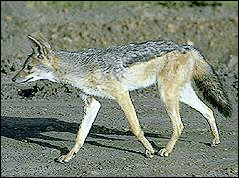

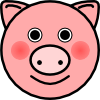

In [44]:
from PIL import Image
img_jpg = Image.open('Python09-Parallel_extra/image.jpg')
img_png = Image.open('Python09-Parallel_extra/image.png')
display(img_jpg)
display(img_png)

<hr>

## Домашнее задание

Это задание является факультативным. Вы можете выполнить его, если желаете поднять балл.

**Задача**: Необходимо реализовать закачку картинок, используя `requests`, из Интернета (с какого-нибудь открытого ресурса, например, https://commons.wikimedia.org/wiki/Category:Images), 50-100 штук, с помощью `threading` и `multiprocessing`, замерить скорость, и сравнить с обычной нераспараллеленной реализацией. Программа должна называться download.py и принимать следующие аргументы:
```
    --dataset-list=/path/to/dataset.txt - Путь к файлу со списком ссылок на картинки (одна строка - одна ссылка). Этот файл необходимо сделать самостоятельно. Убедитесь, что по ссылке скачивается именно изображение, а не какие-то другие файлы (например, HTML).
    --dataset-path=/path/to/downloaded/files/ - Путь к папке, куда будут сохраняться скачанные картинки. В этой папке вы должны создать папки по номеру строки (0, 1, ..., N-1), куда сохранить соответствующие картинки. Если папка не существует, то её надо создать.
    --parallel-mode=MODE [off|multithreading|multiprocessing] - режим параллелизма: отключен (последовательное скачивание), многопоточный или многопроцессный.
    --num-parallel=N - Число параллельных задач скачивания: потоков или процессов; в не параллельном режиме (parallel-mode=off) этот параметр игнорируется.
    --num-retry=K (default: 3) - Число повторных попыток скачивания, если предыдущие запросы завершились с ошибкой (т.е. HTTP-код, отличный от 200).
    --stats-file=/path/to/stats.csv - Путь к файлу, в который будет записана статистика скачивания файлов.
```

Пример вызова скрипта: python download.py --dataset-list=/path/to/images.txt --dataset-path=/path/to/saved/files/ --parallel-mode=multithreading --num-parallel=8 --stats-file=/path/to/stats.csv
Убедитесь, что ваша программа не падает в различных режимах запуска. Программа должна уметь парировать различные исключительные ситуации, такие как таймауты HTTP-запросов или отсутствие папки для скачивания.

В конец файла, переданного аргументом --stats-file, должна быть дописана строка следующего формата:
MODE;N;NUM_FILES;DOWN_TIME

Где:
MODE - режим параллелизма (аргумент, переданный --parallel-mode)
N - Число параллельных задач скачивания (аргумент, переданный --num-parallel)
NUM_FILES - количество успешно скачанных файлов
DOWN_TIME - суммарное время загрузки всех файлов (от начала скачивания первого файла до завершения скачивания последнего файла).

В каждом из режимов программа должна быть вызвана 8 раз, для N=1..8 (кроме режима --parallel-mode=off, там достаточно одного вызова). Таким образом, в файле статистики должно быть 17 строк (8 для режима многопоточного параллелизма, 8 для многопроцессного параллелизма и 1 для последовательного режима)

Далее, второй скрипт stats.py должен проанализировать содержимое файла статистики и построить три графика (для каждого из режимов) зависимости среднего времени скачивания одного файла (т.е. значение AVG_DOWN_TIME=DOWN_TIME/NUM_FILES) от N. N должно быть отложено по горизонтальной оси, AVG_DOWN_TIME - по вертикальной. Оси должны быть подписаны, графики должны быть различимы и построены на общем поле в одних координатах. На графике должна быть отображена сетка. График для --parallel-mode=off должен являться горизонтальной линией (т.е. не зависеть от N). График должен быть сохранён в файл stats.png.

Необходимо будет прислать файл со списком ссылок images.txt, скрипт с реализацией программы скачивания download.py, файл с данными статистики stats.csv, скрипт с анализом статистики stats.py и файл с графиком stats.png.

Файлы download.py и stats.py должны проходить проверку `pylint (версии 3.3.1)` как минимум на 9 из 10 баллов.